In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import torch
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

In [36]:
data = {'rsa': {}, 'nc': {}}
rsa_path = f'../results2/seed_42/*/rsa/*/*.pt'
nc_path = f'../results2/seed_42/*/noise_ceilings/*.pt'

files = sorted(glob.glob(rsa_path))
for file in files:
    splits = file.split('/')
    dset = splits[-4]
    model = splits[-2]
    species = dset if dset == 'allen' else 'monkey'
    if species not in data['rsa']:
        data['rsa'][species] = {}
    if species == 'allen':
        area, depth, cre_line = file.split('/')[-1].split('_')[-3:]
        cre_line = cre_line.replace('.pt', '')
        stim_type = '_'.join(file.split('/')[-1].split('_')[2:-3])
        if f'{stim_type}_{area}_{depth}_{cre_line}' not in data['rsa'][species]:
            data['rsa'][species][f'{stim_type}_{area}_{depth}_{cre_line}'] = {}
        data['rsa'][species][f'{stim_type}_{area}_{depth}_{cre_line}'][model] = torch.load(file)
    elif species == 'monkey':
        area = splits[-1].split('_')[-1].split('.')[0]
        if f'{area}' not in data['rsa'][species]:
            data['rsa'][species][area] = {}
        data['rsa'][species][area][model] = torch.load(file)
    
files = sorted(glob.glob(nc_path))
for file in files:
    dset = file.split('/')[-3]
    species = dset if dset == 'allen' else 'monkey'
    if species not in data['nc']:
        data['nc'][species] = {}
    if species == 'allen':
        area, depth, cre_line = file.split('/')[-1].split('_')[-3:]
        cre_line = cre_line.replace('.pt', '')
        stim_type = '_'.join(file.split('/')[-1].split('_')[:-3])
        data['nc'][species][f'{stim_type}_{area}_{depth}_{cre_line}'] = torch.load(file)
    elif species == 'monkey':
        area = file.split('/')[-1].split('_')[-1].split('.')[0]
        data['nc'][species][f'{area}'] = torch.load(file)

In [4]:
def plot(data, nrb, mode, config):
    area = config.get('area', None)
    stim_type = config.get('stim_type', None)
    depth = config.get('depth', None)
    cre_line = config.get('cre_line', None)
    
    rsa = data['rsa'][mode][f'{stim_type}_{area}_{depth}_{cre_line}'] if mode == 'allen' else data['rsa'][mode][area]
    noise_ceiling = data['nc'][mode][f'{stim_type}_{area}_{depth}_{cre_line}'] if mode == 'allen' else data['nc'][mode][area]
    
    dfs = []
    for species, kt in rsa.items():
        model, nrb_ = species.split('_')
        df_model = pd.DataFrame(kt).melt(var_name='Layer', value_name='RSA')
        df_model['RSA'] /= np.median(noise_ceiling)
        df_model['Model'] = model.capitalize()
        df_model['Nrb'] = int(nrb_)
        df_model['Path'] = [layer[:2] if layer[:2] in ['p1', 'p2'] else '' for layer in df_model['Layer']]
        df_model['Layer'] = [layer[3:] if layer[:2] in ['p1', 'p2'] else layer for layer in df_model['Layer']]
        dfs.append(df_model)
    
    df = pd.concat(dfs)
    df = df.drop_duplicates(keep='first')
    baseline = df.loc[df['Layer'] == 'pixel']['RSA']
    baseline = baseline.drop_duplicates(keep='first')[0]
    df = df.loc[df.Nrb == nrb]
    df = df.loc[df.Path != 'p2']
    df = df.loc[df['Layer'] != 'pixel']
    df.loc[df['Model'] == 'James', 'Model'] = 'Treeshrew2'
    
    custom_order = ['s1'] + [f'res_block{i}' for i in range(1, nrb+1)] + ['out']
    df['Layer'] = pd.Categorical(df['Layer'], categories=custom_order, ordered=True)
    df = df.sort_values(['Model', 'Layer']).reset_index(drop=True)
    
    
    
    plt.figure(figsize=(12, 6))
    colors = ['black', 'red', 'darkblue', 'blue']
    sns.pointplot(data=df, x='Layer', y='RSA', hue='Model', palette=colors, dodge=0.2, estimator='median', err_kws={'linewidth': 1}, markersize=2, linestyle='none')
    
    x_limits = plt.xlim()
    plt.axhline(baseline, color='black', linestyle='--', label='Pixel')
    
    plt.xlabel('Layers')
    plt.xticks(rotation=45)
    plt.ylabel('RDM similarity\n(noise corrected)')
    plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.xlim(x_limits)
    title = f'{mode.capitalize()} {area}, NRB: {nrb}'
    title += f'\nStimulus: {stim_type}, Depth: {depth}, Cre line: {cre_line}' if mode == 'allen' else ''
    plt.title(title)
    plt.show()

In [58]:
matplotlib.rcParams.update({'font.size': 20})

def plot_max_sim(data, nrb, mode, config):
    area = config.get('area', None)
    stim_type = config.get('stim_type', None)
    depth = config.get('depth', None)
    cre_line = config.get('cre_line', None)
    
    rsa = data['rsa'][mode][f'{stim_type}_{area}_{depth}_{cre_line}'] if mode == 'allen' else data['rsa'][mode][area]
    noise_ceiling = data['nc'][mode][f'{stim_type}_{area}_{depth}_{cre_line}'] if mode == 'allen' else data['nc'][mode][area]
    fix_pixel(rsa)
    
    dfs = []
    for model, kt in rsa.items():
        # model, nrb_ = species.split('_')
        df_model = pd.DataFrame(kt).melt(var_name='Layer', value_name='RSA')
        df_model['RSA'] /= np.median(noise_ceiling)
        df_model['Model'] = model  # .capitalize()
        # df_model['Nrb'] = int(nrb_)
        df_model['Path'] = [layer[:2] if layer[:2] in ['p1', 'p2'] else '' for layer in df_model['Layer']]
        df_model['Layer'] = [layer[3:] if layer[:2] in ['p1', 'p2'] else layer for layer in df_model['Layer']]
        dfs.append(df_model)
    
    df = pd.concat(dfs)
    df = df.drop_duplicates(keep='first')
    baseline = df.loc[df['Layer'] == 'pixel']['RSA']
    baseline = baseline.drop_duplicates(keep='first')[0]
    # df = df.loc[df.Nrb == nrb]
    df = df.loc[df.Path != 'p2']
    df.loc[df['Model'] == 'Random', 'Model'] = 'Untrained'
    df = df.loc[df['Layer'] != 'pixel']
    df = df.loc[df['Model'] != 'James']
    # df.groupby(['Model', 'Layer']).median().groupby('Model').idxmax()['RSA']
    median_df = df.groupby(['Model', 'Layer'])['RSA'].median().reset_index()
    max_median_layers = median_df.loc[median_df.groupby('Model')['RSA'].idxmax()]
    df = df[df.set_index(['Model', 'Layer']).index.isin(max_median_layers.set_index(['Model', 'Layer']).index)].reset_index(drop=True)
    
    # custom_order = ['Untrained', 'Treeshrew', 'Rat']
    # df['Model'] = pd.Categorical(df['Model'], categories=custom_order, ordered=True)
    # df = df.sort_values(['Model']).reset_index(drop=True)
    
    plt.figure(figsize=(6, 9))
    # colors = ['black', 'blue', 'red']
    colors = ['red', 'red', 'red', 'blue', 'blue', 'blue']
    sns.pointplot(data=df, x='Model', y='RSA', hue='Model', palette=colors, estimator='median', err_kws={'linewidth': 3}, markersize=15, linestyle='none')
    
    # x_limits = plt.xlim()
    # plt.axhline(baseline, color='black', linestyle='--', label='Pixel')
    
    plt.xlabel('')
    plt.xticks(rotation=90, fontsize=20)
    plt.ylabel('Max RDM similarity\n(noise corrected)', fontsize=30)
    # plt.legend(title='Model', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True)
    # plt.xlim(x_limits)
    # title += f'\nStimulus: {stim_type}, Depth: {depth}, Cre line: {cre_line}' if mode == 'allen' else ''
    plt.title(f'{area}' if area != 'VISl' else 'VISlm', fontsize=50)
    plt.tight_layout()
    plt.savefig(f'../results2/seed_42/{area}_max_sim.svg')
    plt.show()
    return df

In [59]:
def fix_pixel(rsa):
    for k, v in rsa.items():
        if 'pixel' in v:
            n = len(v['s1'])
            if n != len(v['pixel']):
                v['pixel'] = v['pixel'].repeat(n)

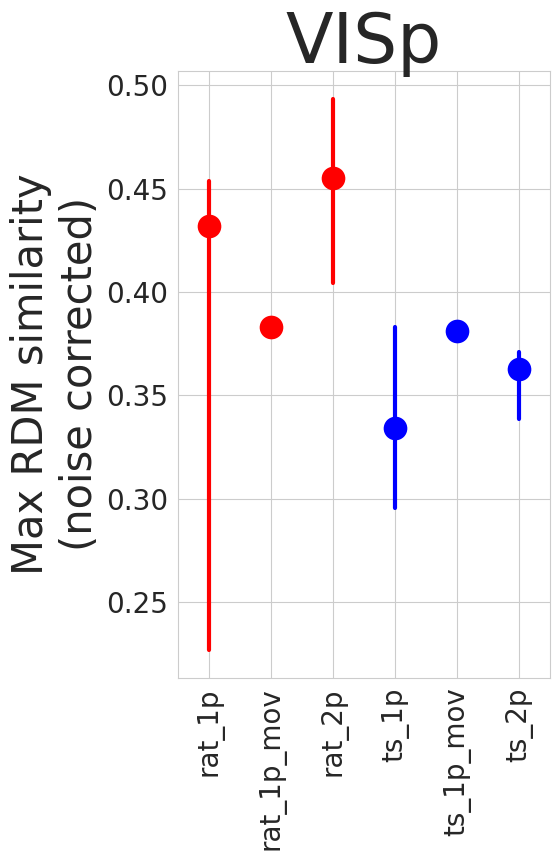

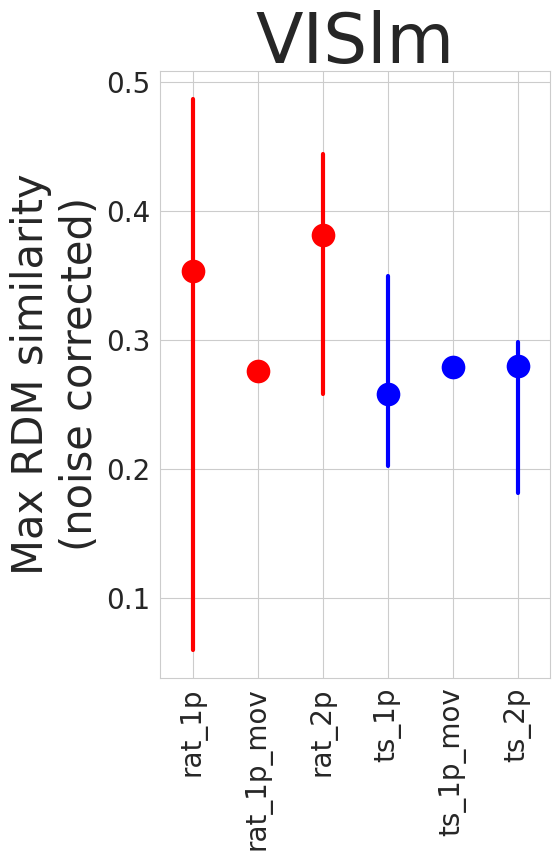

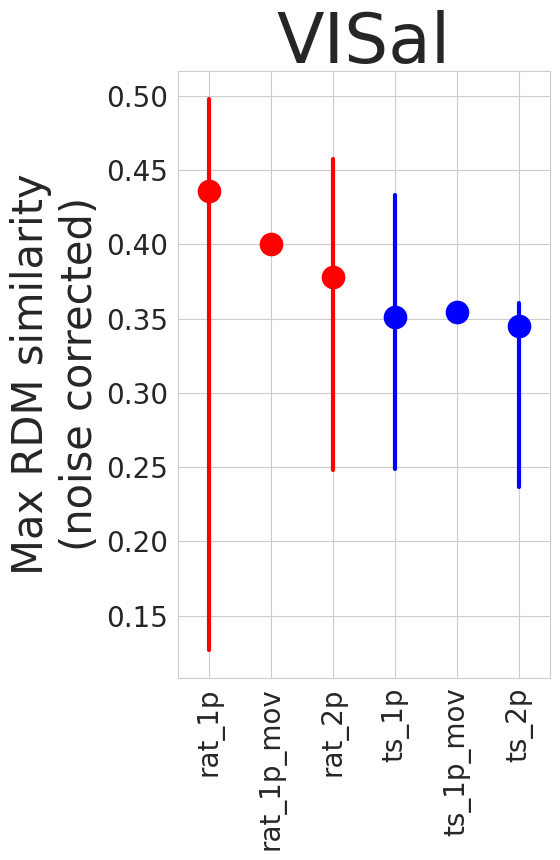

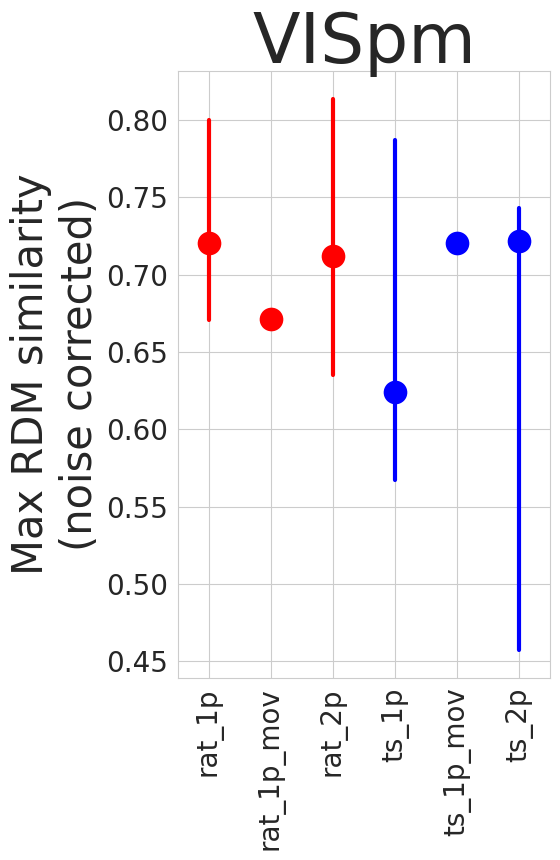

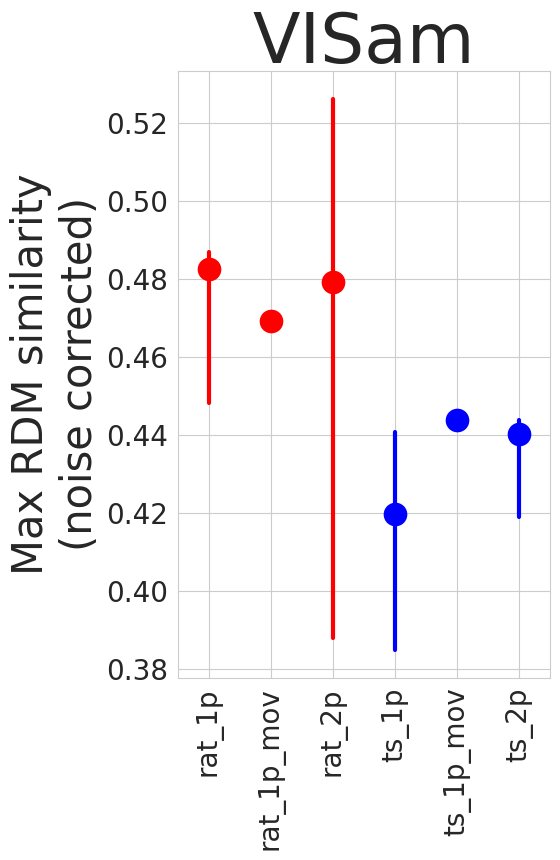

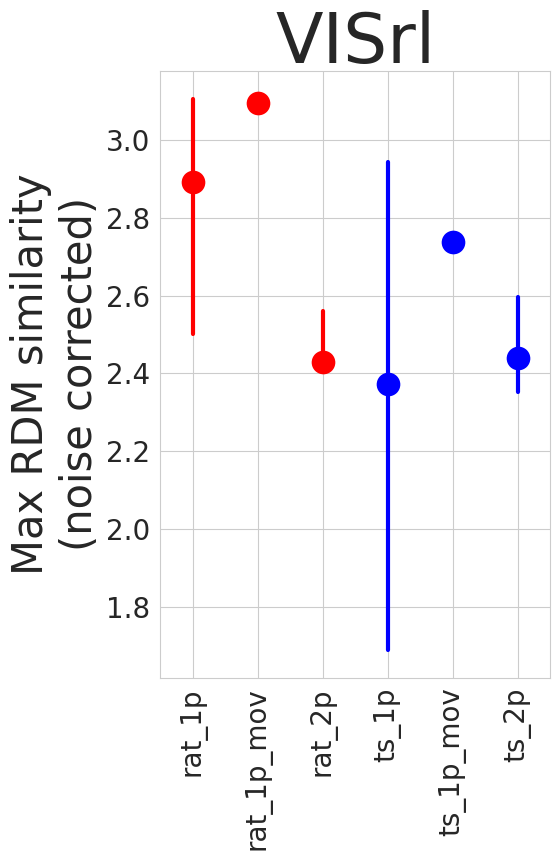

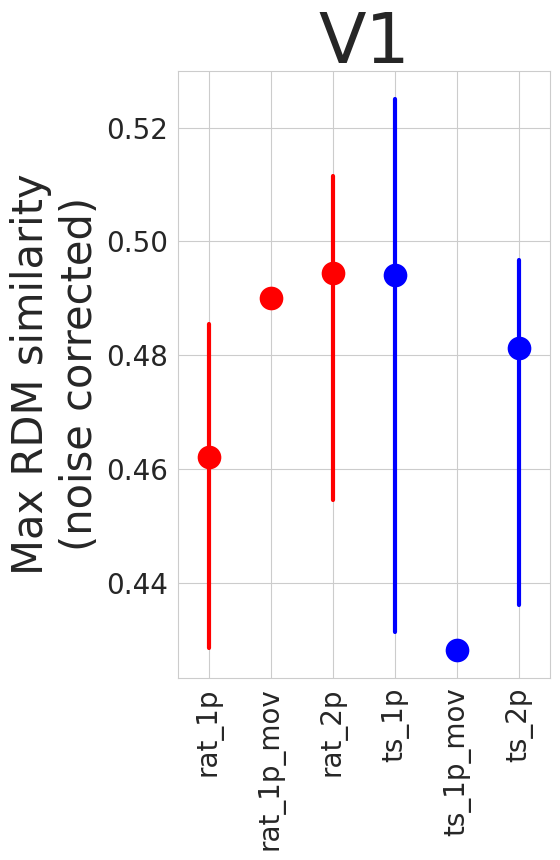

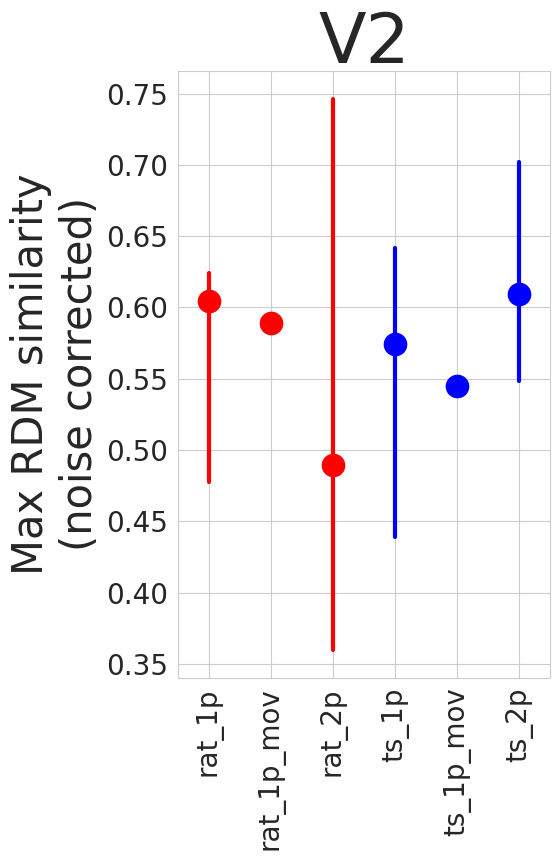

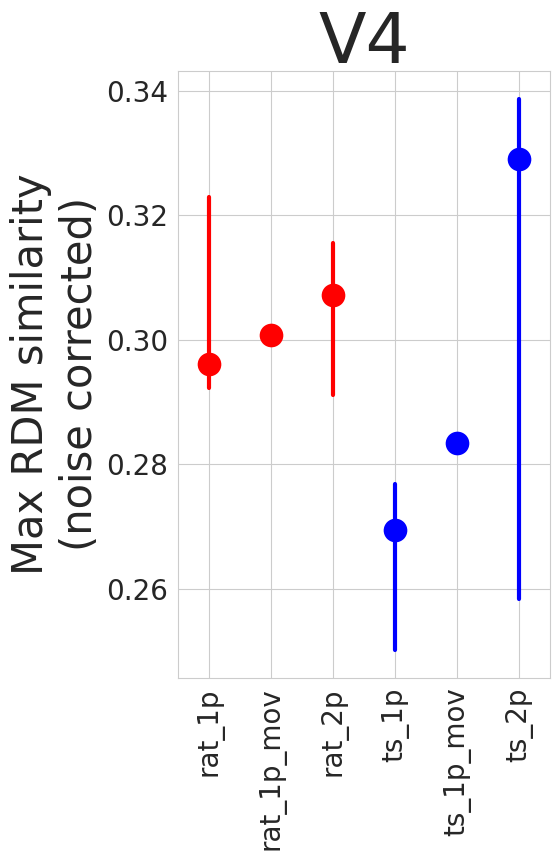

In [60]:
nrb = 6

for mode in ['allen', 'monkey']:
    
    if mode == 'allen':
        stim_type = 'natural_scenes'
        depth = 275
        cre_line = 'Cux2-CreERT2'
        for area in ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam', 'VISrl']:
            config = {'area': area, 'stim_type': stim_type, 'depth': depth, 'cre_line': cre_line}
            # plot(data, nrb, mode, config)
            plot_max_sim(data, nrb, mode, config)
    
    if mode == 'monkey':
        for area in ['V1', 'V2', 'V4']:
            config = {'area': area}
            # plot(data, nrb, mode, config)
            plot_max_sim(data, nrb, mode, config)

# plot(data, nrb, mode, config)
# df = plot_max_sim(data, nrb, mode, config)
# df

In [65]:
matplotlib.rcParams.update({'font.size': 15})

def plot_hierarchy(animal):
    if animal == 'mouse':
        stim_type = 'natural_scenes'
        depth = 275
        cre_line = 'Cux2-CreERT2'
        mode = 'allen'
        areas = ['VISp', 'VISl', 'VISal', 'VISpm', 'VISam']
        config = {'stim_type': stim_type, 'depth': depth, 'cre_line': cre_line}
    else:
        areas = ['V1', 'V2', 'V4']
        mode = 'monkey'
        config = {}
    
    dfs = []
    for area in areas:
        stim_type = config.get('stim_type', None)
        depth = config.get('depth', None)
        cre_line = config.get('cre_line', None)
        an = 'rat' if mode == 'allen' else 'ts'
        if area == 'V1':
            mode = 'monkey'
    
        rsa = data['rsa'][mode][f'{stim_type}_{area}_{depth}_{cre_line}'] if mode == 'allen' else data['rsa'][mode][area]
        noise_ceiling = data['nc'][mode][f'{stim_type}_{area}_{depth}_{cre_line}'] if mode == 'allen' else data['nc'][mode][area]
        
        for model, kt in rsa.items():
            # model, nrb_ = species.split('_')
            
            if an in model:
                df_model = pd.DataFrame(kt).melt(var_name='Layer', value_name='RSA')
                df_model['RSA'] /= np.median(noise_ceiling)
                df_model['Model'] = model  # .capitalize()
                # df_model['Nrb'] = int(nrb_)
                df_model['Area'] = area if area != 'VISl' else 'VISlm'
                df_model['Relative'] = df_model['RSA'] / df_model.max()['RSA']
                df_model['Path'] = [layer[:2] if layer[:2] in ['p1', 'p2'] else '' for layer in df_model['Layer']]
                df_model['Layer'] = [layer[3:] if layer[:2] in ['p1', 'p2'] else layer for layer in df_model['Layer']]
                dfs.append(df_model)

    df = pd.concat(dfs)
    df = df.drop_duplicates(keep='first')
    # df = df.loc[df.Nrb == 6]
    df = df.loc[df.Path != 'p2']
    df = df.loc[df['Layer'] != 'pixel']
    
    plt.figure(figsize=(15, 9))
    sns.lineplot(data=df, x='Layer', y='Relative', hue='Area', estimator='median', errorbar=None, linewidth=3)
    plt.xlabel('Layer', fontsize=30)
    plt.xticks(list(range(0, 8)), list(range(1, 9)), fontsize=20)
    plt.ylabel('RDM similarity\nrelative to maximum for area', fontsize=30)
    # plt.legend(title='Area', bbox_to_anchor=(1.01, 1), loc='upper left')
    plt.grid(True)
    plt.title(f'Hierarchical order of {animal} visual areas', fontsize=40)
    plt.tight_layout()
    plt.savefig(f'../results2/seed_42/{animal}_hierarchy.svg')
    plt.show()

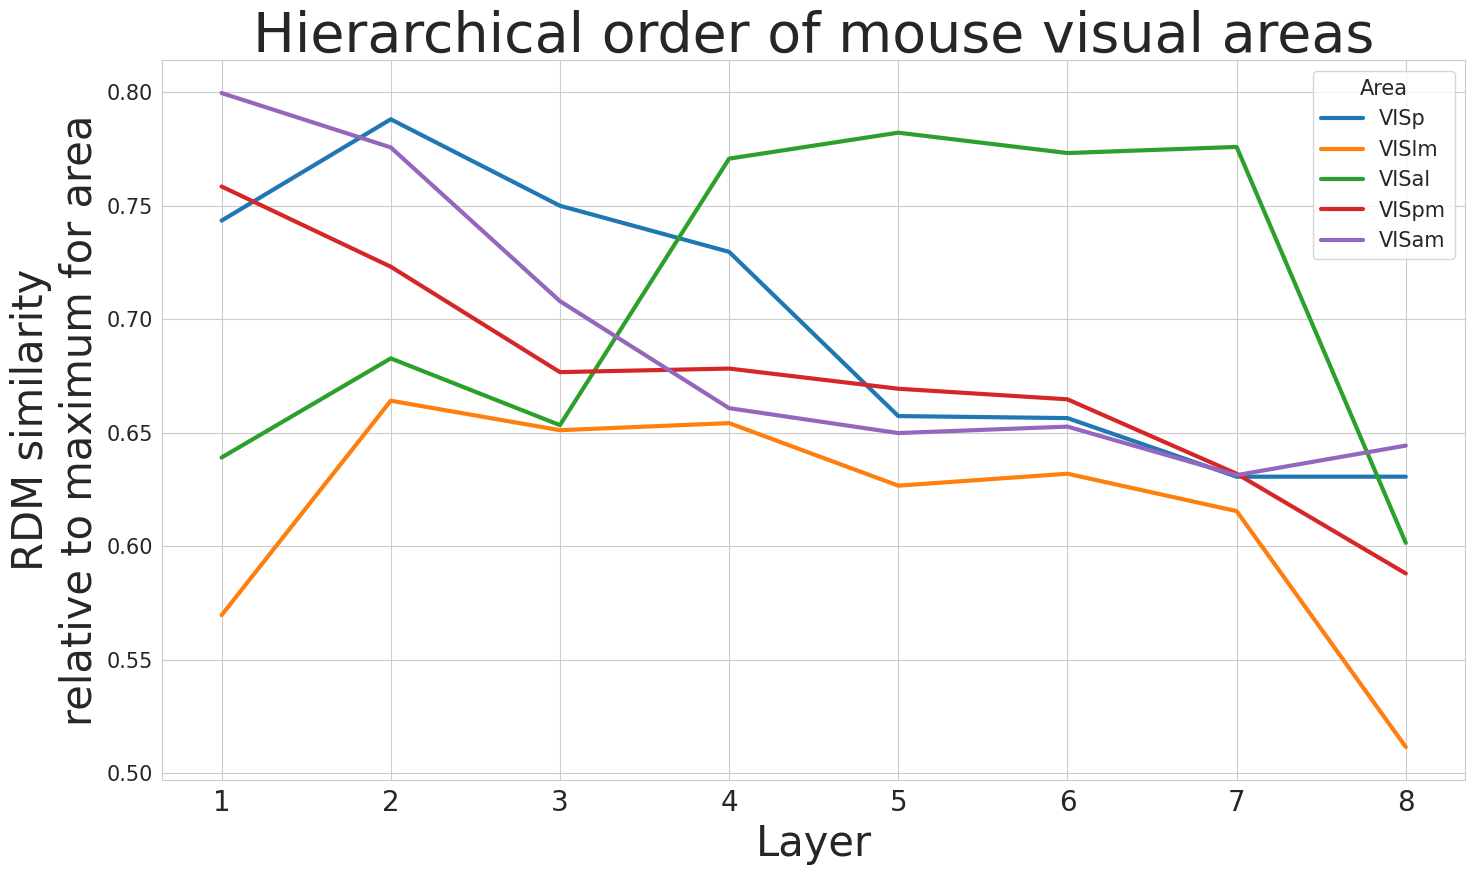

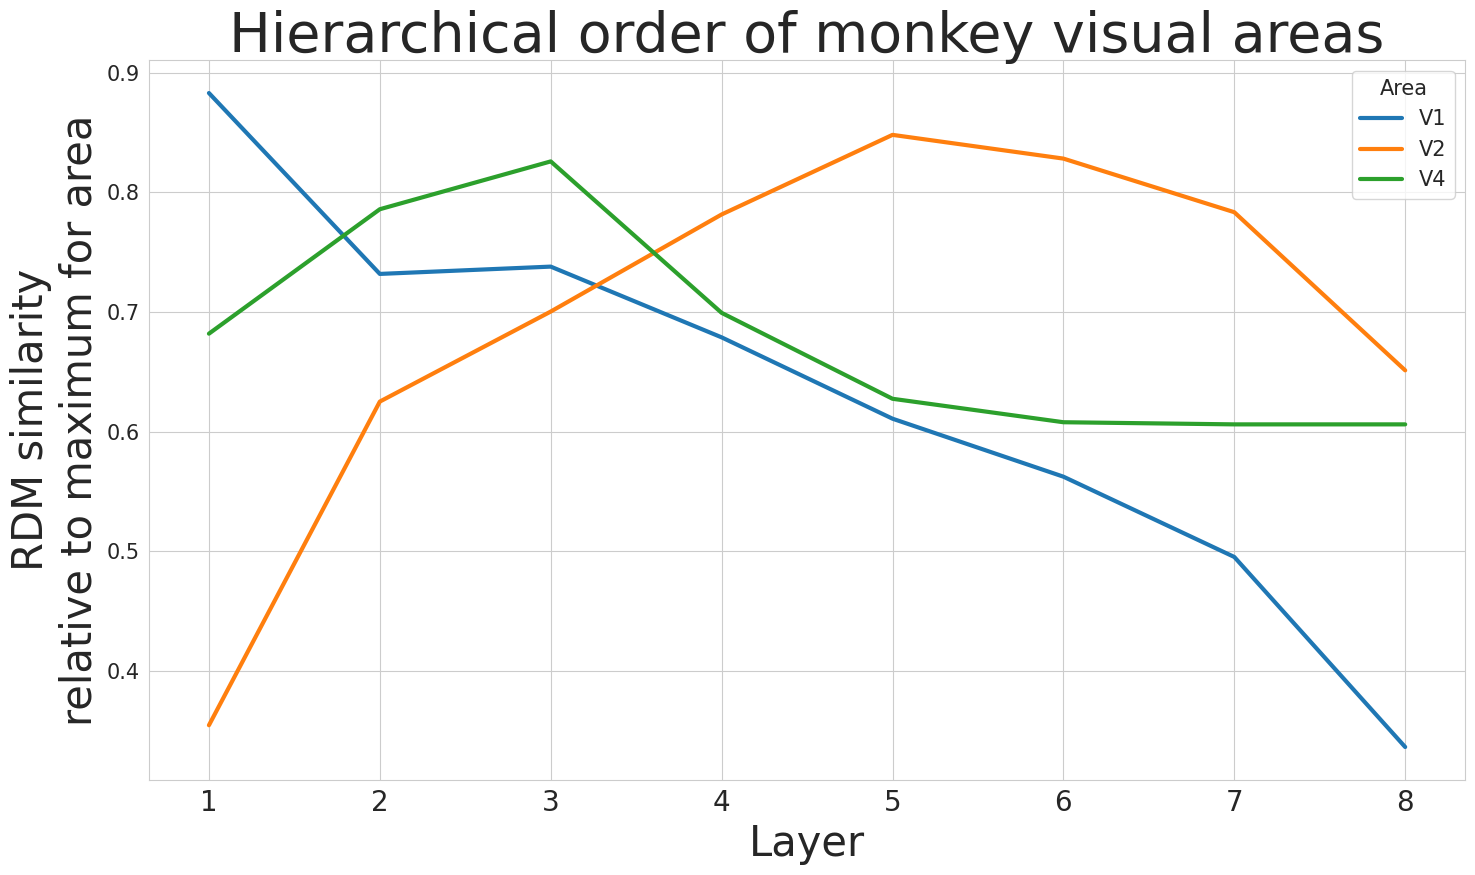

In [66]:
plot_hierarchy('mouse')
plot_hierarchy('monkey')

In [6]:
from IPython.display import display
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
import ipywidgets as widgets

pio.renderers.default = "jupyterlab+png"

In [7]:
def plot_rsa(data, area, nrb, noise_corrected=False, show_layers=True, show_legend=False):
    rsa = data['rsa']
    noise_ceiling = data['nc']
    
    data = []
    for species, kt in rsa.items():
        model, nrb_ = species.split('_')
        df_model = pd.DataFrame(kt)
        if noise_ceiling is not None and noise_corrected:
            df_model /= np.median(noise_ceiling)
        df_med = df_model.median(axis=0)
        df_err = df_model.sem(axis=0)
        df_model = pd.concat([df_med, df_err], axis=1)
        df_model.columns = ['RSA', 'Error']
        df_model['Layer'] = df_model.index
        df_model['Model'] = model.capitalize()
        df_model['Nrb'] = int(nrb_)
        df_model['Path'] = [layer[:2] if layer[:2] in ['p1', 'p2'] else '' for layer in df_model['Layer']]
        df_model['Layer'] = [layer[3:] if layer[:2] in ['p1', 'p2'] else layer for layer in df_model['Layer']]
        df_model.reset_index(drop=True, inplace=True)
        data.append(df_model)

    df = pd.concat(data)
    # df.loc[df['Layer'] == 'pixel', 'Model'] = 'Baseline'
    # df = df.drop_duplicates(keep='first')
    
    df = df.loc[df.Path != 'p2']
    if show_layers:
        df = df.loc[df.Nrb == nrb]
    df.loc[df['Layer'] == 'pixel', 'Model'] = 'Baseline'
    df = df.drop_duplicates(keep='first')
    custom_order = ['pixel', 's1'] + [f'res_block{i}' for i in range(1, nrb+1)] + ['out']
    if show_layers:
        df['Layer'] = pd.Categorical(df['Layer'], categories=custom_order, ordered=True)
        df = df.sort_values('Layer').reset_index(drop=True)
    else:
        df = df.reset_index(drop=True).groupby(['Model'], as_index=False).apply(lambda x: x.loc[x['RSA'].idxmax()]).reset_index(drop=True)
    
    # df['Model_Path'] = df['Model'] + df['Path'].replace({'': '', 'p1': ' P1', 'p2': ' P2'})
    model_names = ['Baseline', 'Treeshrew', 'James', 'Rat', 'Random']
        
    # model_names = df['Model_Path'].unique()
    # complete_index = pd.MultiIndex.from_product([model_names, df['Layer']], names=['Model_Path', 'Layer'])
    # df.set_index(['Model_Path', 'Layer'], inplace=True)
    # df = df.reindex(complete_index).reset_index()
    
    # Dodge setup
    layer_order = {layer: i for i, layer in enumerate(df['Layer'].unique())}
    df['Layer_Index'] = df['Layer'].map(layer_order).astype(int)

    dodge_amount = 0.4  # Adjust this value as needed for clarity
    dp = np.linspace(-dodge_amount/2, dodge_amount/2, 4)
    dodge_positions = [0, *dp]
    
    # Create a Plotly figure
    fig = go.Figure()
    # colors = ['black', 'darkblue', 'blue', 'deepskyblue', 'darkred', 'red', 'orange']
    colors = ['black', 'blue', 'darkblue','red', 'green']
    color_dict = {model: colors[i % len(colors)] for i, model in enumerate(model_names)}
    
    for i, model in enumerate(model_names):
        # len 28
        filtered_df = df[df['Model'] == model].copy()
        # filtered_df = df[df['Model_Path'] == model_path].copy()
        filtered_df['DodgeX'] = filtered_df['Layer_Index'] + dodge_positions[i]
        fig.add_trace(go.Scatter(
            x=filtered_df['DodgeX'] if show_layers else filtered_df['Model'],
            y=filtered_df['RSA'],
            error_y=dict(type='data', array=filtered_df['Error'], visible=True),
            mode='markers',
            name=model,
            marker=dict(color=color_dict[model]),
            showlegend=show_legend if show_layers else False,
        ))

    # Adding noise ceiling if applicable
    if noise_ceiling is not None and not noise_corrected:
        med = np.median(noise_ceiling)
        sd = np.std(noise_ceiling)
        fig.add_trace(go.Scatter(x=list(layer_order.values()), y=[med]*len(df['Layer'].unique()), mode='lines',
                                 name='Noise Ceiling Median', line=dict(dash='dash', color='black'), showlegend=show_legend,))
        fig.add_traces([
            go.Scatter(x=list(layer_order.values()), y=[med+sd]*len(df['Layer'].unique()), fill='tonexty', mode='lines',
                       line=dict(color='gray'), name='Noise Ceiling SD', showlegend=show_legend,),
            go.Scatter(x=list(layer_order.values()), y=[med-sd]*len(df['Layer'].unique()), fill=None, mode='lines',
                       line=dict(color='gray'), showlegend=False,),
        ])
    if show_layers:
        fig.update_layout(title=area,
                          xaxis=dict(
                              tickvals=list(layer_order.values()),
                              ticktext=list(layer_order.keys())
                          ))
    return fig, layer_order

In [ ]:
# Assuming 'rsa' data is structured appropriately and your plot_rsa function is adapted to return dataframes or similar data structures.
areas = ['VISl', 'VISp', 'VISpm', 'VISal', 'VISam']
depths = [175, 275]
cre_line = 'Cux2-CreERT2'
seed = 42

# Create widgets for depth and noise options
depth_dropdown = widgets.Dropdown(options=depths, value=275, description='Depth:')
stim_dropdown = widgets.Dropdown(options=['natural_scenes', 'natural_movie_one'], value='natural_scenes', description='Stimulus:')
nrb_dropdown = widgets.Dropdown(options=[6, 8, 10], value=6, description='NRB:')
noise_toggle = widgets.ToggleButtons(options=['Noise Corrected', 'Noise Ceiling'])
type_toggle = widgets.ToggleButtons(options=['Layers', 'Models'])

def update_plots(change):
    # Create a subplot layout
    fig = make_subplots(rows=3, cols=3, subplot_titles=areas + ['', 'V1', 'V2', ''], vertical_spacing=0.05)
    
    stim_type = stim_dropdown.value
    depth = depth_dropdown.value
    noise_corrected = noise_toggle.value == 'Noise Corrected'
    nrb = nrb_dropdown.value
    type_plot = type_toggle.value
    
    for i, area in enumerate(areas, start=1):
        subdata = {'rsa': data['rsa']['allen'][f'{stim_type}_{area}_{depth}_{cre_line}'], 'nc': data['nc']['allen'][f'{stim_type}_{area}_{depth}_{cre_line}']}
        subfig, layer_order = plot_rsa(subdata, area, nrb=nrb, noise_corrected=noise_corrected, show_layers=(type_plot == 'Layers'), show_legend=(i == 1))
        traces = subfig.data if noise_corrected else reversed(subfig.data)
        for trace in traces:
            fig.add_trace(trace, row=(i-1)//3 + 1, col=(i-1)%3 + 1)
    
    for i, area in enumerate(['V1', 'V2'], start=1):
        subdata = {'rsa': data['rsa']['monkey'][area], 'nc': data['nc']['monkey'][area]}
        subfig, layer_order = plot_rsa(subdata, area, nrb=nrb, show_layers=(type_plot == 'Layers'), noise_corrected=noise_corrected, show_legend=False)
        traces = subfig.data if noise_corrected else reversed(subfig.data)
        for trace in traces:
            fig.add_trace(trace, row=3, col=(i-1)%3 + 1)
            
    fig.update_xaxes(ticklabelstep=1)
    if type_plot == 'Layers':
        fig.update_xaxes(tickvals=list(layer_order.values()), ticktext=list(layer_order.keys()))
    fig.update_xaxes(title_text="", showticklabels=False, row=1, col=1)
    fig.update_xaxes(title_text="", showticklabels=False, row=1, col=2)
    fig.update_xaxes(title_text="Layer" if type_plot == 'Layers' else 'Model', showticklabels=True, row=1, col=3)
    fig.update_xaxes(title_text="", showticklabels=False, row=2, col=1)
    fig.update_xaxes(title_text="", showticklabels=False, row=2, col=2)
    fig.update_xaxes(title_text="Layer" if type_plot == 'Layers' else 'Model', showticklabels=True, row=3, col=1)
    fig.update_xaxes(title_text="Layer" if type_plot == 'Layers' else 'Model', showticklabels=True, row=3, col=2)
    fig.update_yaxes(title_text='RDM similarity<br>(noise corrected)' if noise_corrected else 'RDM similarity', showticklabels=True, row=1, col=1)
    fig.update_yaxes(title_text='RDM similarity<br>(noise corrected)' if noise_corrected else 'RDM similarity', showticklabels=True, row=2, col=1)
    fig.update_yaxes(title_text='RDM similarity<br>(noise corrected)' if noise_corrected else 'RDM similarity', showticklabels=True, row=3, col=1)
    fig.update_layout(height=1800, width=2000, 
                      title_text=f'Representational Similarity Analysis between Mouse Visual Areas and ANNs trained with SSL<br>'
                                 f'NRB: {nrb}, cre_line: {cre_line}, depth: {depth}, stimulus: {stim_type}', 
                      title_x=0.5,
                      legend_title='Model')
    with output:
        output.clear_output(wait=True)
        fig.show("notebook")
        
# Observe changes in widgets and update the plots accordingly
depth_dropdown.observe(update_plots, names='value')
stim_dropdown.observe(update_plots, names='value')
noise_toggle.observe(update_plots, names='value')
nrb_dropdown.observe(update_plots, names='value')
type_toggle.observe(update_plots, names='value')

# Set up a container for the widgets
widgets_container = widgets.VBox([depth_dropdown, stim_dropdown, nrb_dropdown, noise_toggle, type_toggle])

# Layout to display widgets and plot output
output = widgets.Output()
display(widgets_container, output)

# Initialize the plots with default values
update_plots(None)

Output()